# Crypto-Assets Cointegration Project

### Modules

In [83]:
import binance_api
import numpy as np
import pandas as pd
import math

import statsmodels
from statsmodels.tsa.stattools import coint
import statsmodels.api as stat
import statsmodels.tsa.stattools as ts

import matplotlib.pyplot as plt
from datetime import datetime, date

import seaborn as sb
# https://www.marketcalls.in/amibroker/computing-cointegration-and-augmented-dickey-fuller-test-in-amibroker-using-python.html#:~:text=Augmented%20Dicky%20Fuller%20test%20is,stationary%20and%20cointegrated%20or%20not.&text=The%20Augmented%20Dicky%20Fuller%20test,want%20to%20reject%20this%20hypothesis.


### Default Values

In [84]:
# default values
nbr_of_coins = 20

interval_long = '1d'
interval_mid ='1h'
interval_short = '5m'

# lookback periods are in days
lookback_long = 14
lookback_mid = 7 * 24
lookback_short = 2 * 12 * 24

#startTime = round(datetime(2021, 12, 4).timestamp()) * 1000
endTime = round(datetime(2022, 2, 19).timestamp()) * 1000

### Get coins with most volume on Binance

In [85]:
# Get all coins, sort them by volume and keep the top x nbr of coins
tickers = pd.DataFrame(binance_api.get_all_tickers())
tickers['volume_usd'] = tickers.apply(lambda row: float(row['volume']) * float(row['lastPrice']), axis=1)
tickers = tickers.sort_values(by='volume_usd', ascending=False)
top_tickers = tickers[:nbr_of_coins]

# Remove PEOPLE because its missing some data
top_tickers = top_tickers[top_tickers['symbol'] != 'PEOPLEUSDT']
print(top_tickers['symbol'].values.tolist())

['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'GALAUSDT', '1000SHIBUSDT', 'AVAXUSDT', 'BTCBUSD', 'SOLUSDT', 'LUNAUSDT', 'SANDUSDT', 'ADAUSDT', 'MANAUSDT', 'DOGEUSDT', 'ETHBUSD', 'BNBUSDT', 'FTMUSDT', 'NEOUSDT', 'MATICUSDT', 'NEARUSDT', 'LINKUSDT']


### Historical Data

In [86]:
# Get historical data for multiple timeframes

# short
historical_data_short = {}
for i in range(0, len(top_tickers)):
    historical_data_short[top_tickers.iloc[i]['symbol']] = pd.DataFrame(binance_api.get_historical_prices(top_tickers.iloc[i]['symbol'], interval_short, None, endTime))
print('Downloaded {} data'.format(interval_short))

# mid
historical_data_mid = {}
for i in range(0, len(top_tickers)):
    historical_data_mid[top_tickers.iloc[i]['symbol']] = pd.DataFrame(binance_api.get_historical_prices(top_tickers.iloc[i]['symbol'], interval_mid, None, endTime))
print('Downloaded {} data'.format(interval_mid))


# long
historical_data_long = {}
for i in range(0, len(top_tickers)):
    historical_data_long[top_tickers.iloc[i]['symbol']] = pd.DataFrame(binance_api.get_historical_prices(top_tickers.iloc[i]['symbol'], interval_long, None, endTime))
print('Downloaded {} data'.format(interval_long))


Downloaded 5m data
Downloaded 1h data
Downloaded 1d data


In [87]:
# Data Sample
historical_data_short['ETHUSDT']

,0,1,2,3,4,5,6,7,8,9,10,11
0,1644947100000,3098.00,3099.49,3089.15,3092.08,5141.391,1644947399999,15900726.96397,9750,1461.135,4518755.57481,0
1,1644947400000,3092.08,3097.98,3091.75,3092.49,3322.943,1644947699999,10284355.97883,5986,1534.291,4748652.56855,0
2,1644947700000,3092.50,3097.57,3090.57,3097.01,2750.934,1644947999999,8515262.31754,5223,1596.246,4941262.29013,0
3,1644948000000,3097.01,3102.00,3091.77,3095.80,5560.918,1644948299999,17222036.54916,7614,2883.346,8932594.88134,0
4,1644948300000,3095.80,3102.00,3095.55,3101.22,2867.450,1644948599999,8887287.72820,5150,1833.271,5681776.33952,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1645245600000,2811.72,2813.37,2810.12,2811.90,1572.810,1645245899999,4422605.70083,2574,547.751,1540356.10872,0
996,1645245900000,2811.90,2812.03,2806.00,2808.59,1921.724,1645246199999,5397122.87709,3215,595.940,1673628.58436,0
997,1645246200000,2808.59,2808.82,2806.51,2807.81,1310.012,1645246499999,3677758.75607,2426,543.850,1526821.44783,0
998,1645246500000,2807.80,2814.28,2807.80,2814.12,2388.567,1645246799999,6714582.67648,2956,1729.953,4862861.59695,0


### Cointegration Example

In [88]:
data_1 = np.asarray(historical_data_short['BTCUSDT'][4].tail(lookback_short)).astype(float)
data_2 = np.asarray(historical_data_short['ETHUSDT'][4].tail(lookback_short)).astype(float)
result = stat.OLS(data_1, data_2).fit()
a = ts.adfuller(result.resid)
print('p-value: {}'.format(a[1]))

p-value: 0.5269048903309012


### Cointegration Matrix

<AxesSubplot:title={'center':'1d resolution'}>

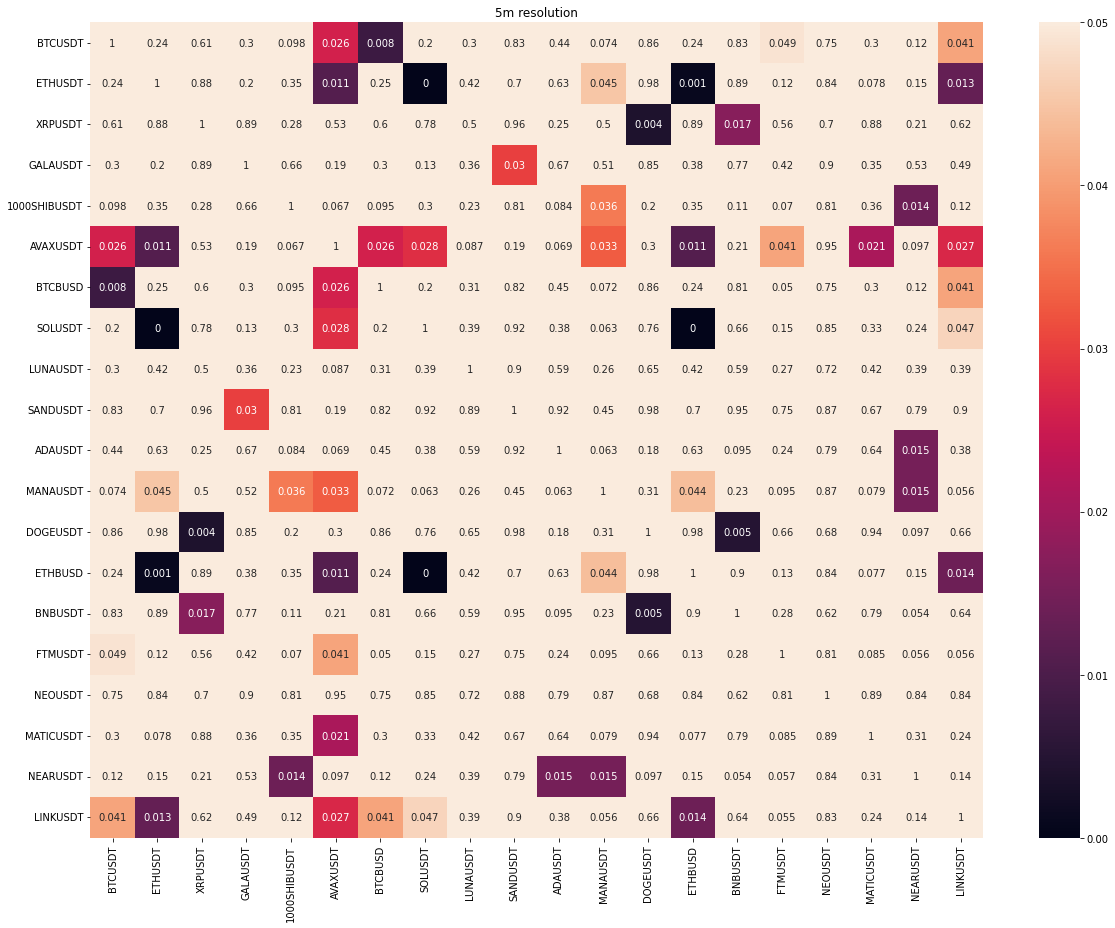

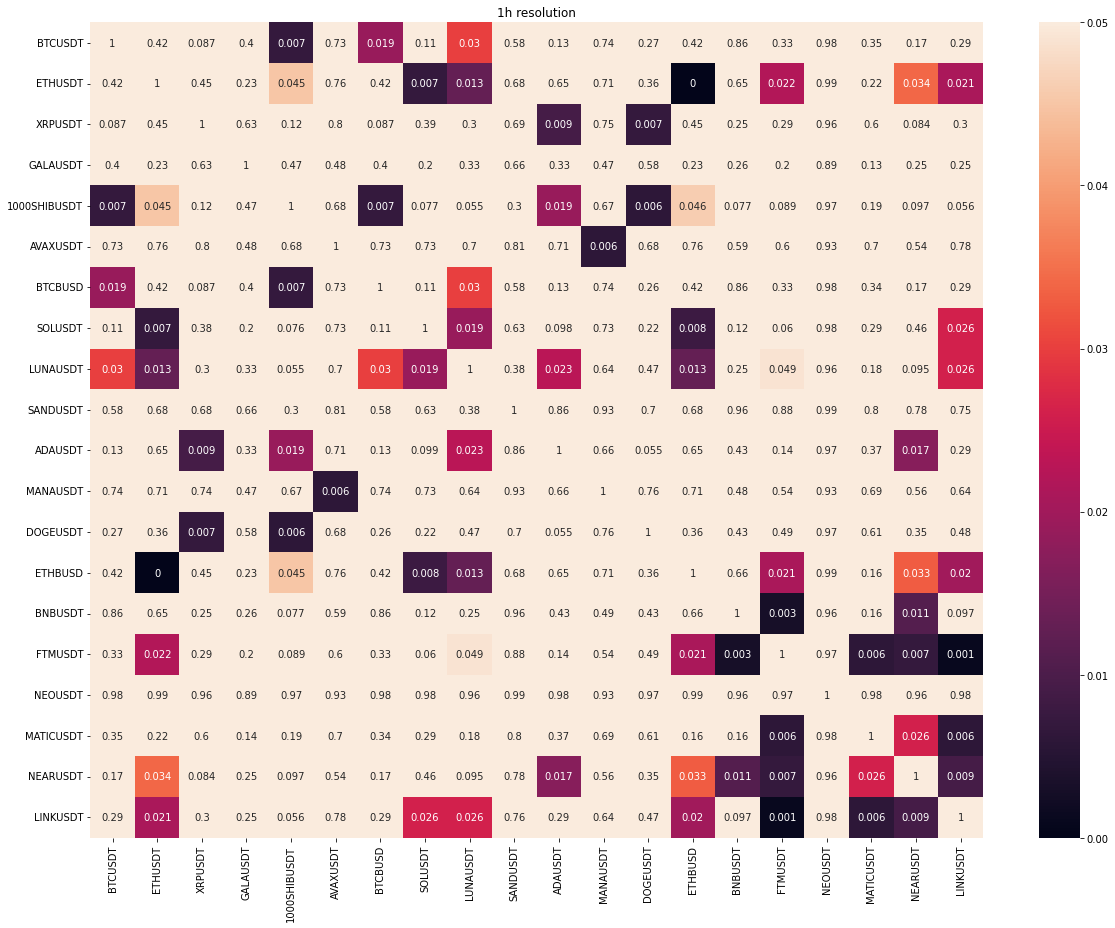

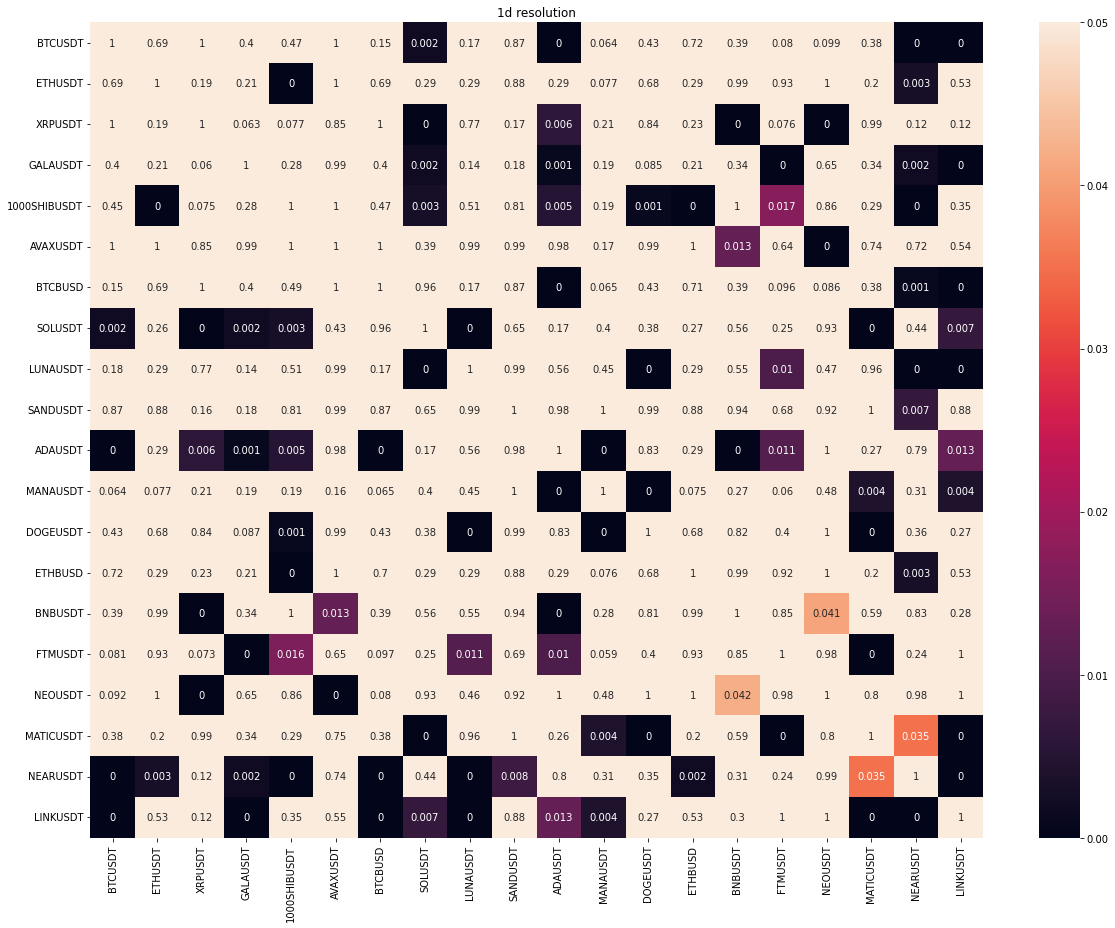

In [89]:
symbols = list(historical_data_short.keys())

# short
coint_matrix_short = pd.DataFrame(index=symbols, columns=symbols)
for i in range(0, len(coint_matrix_short)):
    for j in range(0, len(coint_matrix_short)):
        if i != j:
            #print('{},{}'.format(i,j))
            data_1 = np.asarray(historical_data_short[coint_matrix_short.index[i]][4].tail(lookback_period)).astype(float)
            data_2 = np.asarray(historical_data_short[coint_matrix_short.index[j]][4].tail(lookback_period)).astype(float)
            if len(data_1) == len(data_2):
                result = stat.OLS(data_1, data_2).fit()
                a = ts.adfuller(result.resid)
                pvalue = a[1]
                coint_matrix_short[coint_matrix_short.index[i]][coint_matrix_short.index[j]] = round(pvalue, 3)

coint_matrix_short = coint_matrix_short.fillna(1)

# Show
plt.figure(figsize=(20,15))
plt.title('{} resolution'.format(interval_short))
sb.heatmap(coint_matrix_short, annot=True, vmin=0, vmax=0.05)


# mid
coint_matrix_mid = pd.DataFrame(index=symbols, columns=symbols)
for i in range(0, len(coint_matrix_mid)):
    for j in range(0, len(coint_matrix_mid)):
        if i != j:
            #print('{},{}'.format(i,j))
            data_1 = np.asarray(historical_data_mid[coint_matrix_mid.index[i]][4].tail(lookback_mid)).astype(float)
            data_2 = np.asarray(historical_data_mid[coint_matrix_mid.index[j]][4].tail(lookback_mid)).astype(float)
            if len(data_1) == len(data_2):
                result = stat.OLS(data_1, data_2).fit()
                a = ts.adfuller(result.resid)
                pvalue = a[1]
                coint_matrix_mid[coint_matrix_mid.index[i]][coint_matrix_mid.index[j]] = round(pvalue, 3)

coint_matrix_mid = coint_matrix_mid.fillna(1)

# Show
plt.figure(figsize=(20,15))
plt.title('{} resolution'.format(interval_mid))
sb.heatmap(coint_matrix_mid, annot=True, vmin=0, vmax=0.05)

# long
coint_matrix_long = pd.DataFrame(index=symbols, columns=symbols)
for i in range(0, len(coint_matrix_long)):
    for j in range(0, len(coint_matrix_long)):
        if i != j:
            #print('{},{}'.format(i,j))
            data_1 = np.asarray(historical_data_long[coint_matrix_long.index[i]][4].tail(lookback_long)).astype(float)
            data_2 = np.asarray(historical_data_long[coint_matrix_long.index[j]][4].tail(lookback_long)).astype(float)
            if len(data_1) == len(data_2):
                result = stat.OLS(data_1, data_2).fit()
                a = ts.adfuller(result.resid)
                pvalue = a[1]
                coint_matrix_long[coint_matrix_long.index[i]][coint_matrix_long.index[j]] = round(pvalue, 3)

coint_matrix_long = coint_matrix_long.fillna(1)

# Show
plt.figure(figsize=(20,15))
plt.title('{} resolution'.format(interval_long))
sb.heatmap(coint_matrix_long, annot=True, vmin=0, vmax=0.05)



In [90]:
# Stats
nbr_of_cointegrated_pairs = coint_matrix_short[coint_matrix_short < 0.05].count().sum() / 2
nbr_of_pairs = coint_matrix_long.size / 2
percentage_of_cointegration = nbr_of_cointegrated_pairs / nbr_of_pairs * 100
print('{:.2f}% of the most liquid pairs are cointegrated on the {} data'.format(percentage_of_cointegration, interval_short))

nbr_of_cointegrated_pairs = coint_matrix_mid[coint_matrix_mid < 0.05].count().sum() / 2
nbr_of_pairs = coint_matrix_mid.size / 2
percentage_of_cointegration = nbr_of_cointegrated_pairs / nbr_of_pairs * 100
print('{:.2f}% of the most liquid pairs are cointegrated on the {} data'.format(percentage_of_cointegration, interval_mid))

nbr_of_cointegrated_pairs = coint_matrix_long[coint_matrix_long < 0.05].count().sum() / 2
nbr_of_pairs = coint_matrix_long.size / 2
percentage_of_cointegration = nbr_of_cointegrated_pairs / nbr_of_pairs * 100
print('{:.2f}% of the most liquid pairs are cointegrated on the {} data'.format(percentage_of_cointegration, interval_long))


14.50% of the most liquid pairs are cointegrated on the 5m data
18.50% of the most liquid pairs are cointegrated on the 1h data
24.00% of the most liquid pairs are cointegrated on the 1d data


## Pairs cointegrated on different timeframe 

In [105]:
for i in range(0, len(coint_matrix_long)):
    for j in range(0, len(coint_matrix_long)):
        if coint_matrix_long.iloc[i][j] < 0.05 and coint_matrix_mid.iloc[i][j] < 0.05 and coint_matrix_short.iloc[i][j] < 0.05:
            print('{}/{} pair is cointegrated in 3 timeframes'.format(coint_matrix_long.index[i],coint_matrix_long.index[j]))
        #elif (coint_matrix_long.iloc[i][j] < 0.05 and coint_matrix_mid.iloc[i][j] < 0.05) or (coint_matrix_short.iloc[i][j] < 0.05 and coint_matrix_mid.iloc[i][j] < 0.05):
            #print('{}/{} pair is cointegrated in 2 timeframes'.format(coint_matrix_long.index[i],coint_matrix_long.index[j]))
        #elif coint_matrix_long.iloc[i][j] < 0.05 or coint_matrix_mid.iloc[i][j] < 0.05 or coint_matrix_short.iloc[i][j] < 0.05:
            #print('{}/{} pair is cointegrated in 1 timeframes'.format(coint_matrix_long.index[i],coint_matrix_long.index[j]))
            
            
            
    

SOLUSDT/LINKUSDT pair is cointegrated in 3 timeframes
LINKUSDT/SOLUSDT pair is cointegrated in 3 timeframes


In [102]:
coint_matrix_long.index[1]

'ETHUSDT'